In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score
from sklearn.metrics import f1_score, roc_auc_score, log_loss, RocCurveDisplay
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import GridSearchCV

import mlflow
import mlflow.sklearn
from mlflow.models.signature import infer_signature

In [2]:
credito = pd.read_csv('../data/Credit.csv')
credito.shape

(1000, 21)

In [3]:
credito.head()

,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,...,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker,class
0,<0,6,'critical/other existing credit',radio/tv,1169,'no known savings',>=7,4,'male single',none,...,'real estate',67,none,own,2,skilled,1,yes,yes,good
1,0<=X<200,48,'existing paid',radio/tv,5951,<100,1<=X<4,2,'female div/dep/mar',none,...,'real estate',22,none,own,1,skilled,1,none,yes,bad
2,'no checking',12,'critical/other existing credit',education,2096,<100,4<=X<7,2,'male single',none,...,'real estate',49,none,own,1,'unskilled resident',2,none,yes,good
3,<0,42,'existing paid',furniture/equipment,7882,<100,4<=X<7,2,'male single',guarantor,...,'life insurance',45,none,'for free',1,skilled,2,none,yes,good
4,<0,24,'delayed previously','new car',4870,<100,1<=X<4,3,'male single',none,...,'no known property',53,none,'for free',2,skilled,2,none,yes,bad


In [4]:
def transforma(dataset):
    for col in dataset.columns:
        if dataset[col].dtype == 'object':
            dataset[col] = dataset[col].astype('category').cat.codes

In [5]:
transforma(credito)

In [6]:
credito.head()

,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,...,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker,class
0,2,6,1,7,1169,0,3,4,3,2,...,2,67,1,1,2,3,1,1,1,1
1,1,48,3,7,5951,3,0,2,0,2,...,2,22,1,1,1,3,1,0,1,0
2,0,12,1,4,2096,3,1,2,3,2,...,2,49,1,1,1,2,2,0,1,1
3,2,42,3,5,7882,3,1,2,3,1,...,0,45,1,0,1,3,2,0,1,1
4,2,24,2,1,4870,3,0,3,3,2,...,1,53,1,0,2,3,2,0,1,0


In [7]:
X = credito.iloc[:, 0:20].values
y = credito.iloc[:, 20].values

In [8]:
X

array([[ 2,  6,  1, ...,  1,  1,  1],
       [ 1, 48,  3, ...,  1,  0,  1],
       [ 0, 12,  1, ...,  2,  0,  1],
       ...,
       [ 0, 12,  3, ...,  1,  0,  1],
       [ 2, 45,  3, ...,  1,  1,  1],
       [ 1, 45,  1, ...,  1,  0,  1]], shape=(1000, 20))

In [9]:
X_train, X_test, y_train, y_teste = train_test_split(
    X, y, test_size=0.3, random_state=123
)

In [10]:
# Criando um banco de dados local
mlflow.set_tracking_uri("sqlite:///mlflow.db")

2025/11/21 16:50:15 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2025/11/21 16:50:15 INFO mlflow.store.db.utils: Updating database tables
2025-11-21 16:50:15 INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
2025-11-21 16:50:15 INFO  [alembic.runtime.migration] Will assume non-transactional DDL.
2025-11-21 16:50:15 INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
2025-11-21 16:50:15 INFO  [alembic.runtime.migration] Will assume non-transactional DDL.
2025/11/21 16:50:21 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Modelo:  1e2cc737b1204365b80a11bca2edf615


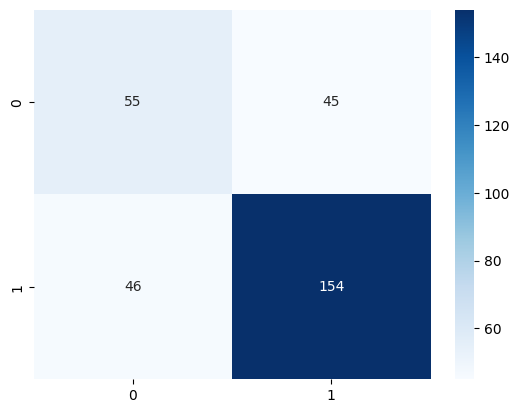

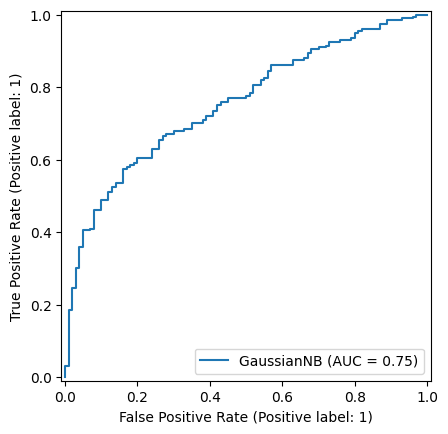

In [11]:
mlflow.set_experiment("nbexperimento")
with mlflow.start_run():
    nb = GaussianNB()
    nb.fit(X_train, y_train)
    previsoes = nb.predict(X_test)
    # Métricas
    acuracia = accuracy_score(y_teste, previsoes)
    recall = recall_score(y_teste, previsoes)
    precision = precision_score(y_teste, previsoes)
    f1 = f1_score(y_teste, previsoes)
    auc = roc_auc_score(y_teste, previsoes)
    log = log_loss(y_teste, previsoes)

    # registra métricas
    mlflow.log_metric("acuracia", acuracia)
    mlflow.log_metric("recall", recall)
    mlflow.log_metric("precision", precision)
    mlflow.log_metric("f1", f1)
    mlflow.log_metric("auc", auc)
    mlflow.log_metric("log", log)

    # Gráficos
    confusion = sns.heatmap(
        confusion_matrix(y_teste, previsoes, labels=[0, 1]),
        annot=True, cmap='Blues', xticklabels=['0', '1'],
        yticklabels=['0', '1'], fmt='g'
    )
    plt.savefig('confusion.png')
    roc = RocCurveDisplay.from_estimator(nb, X_test, y_teste)
    plt.savefig('roc.png')

    # Salvar os gráficos
    mlflow.log_artifact('confusion.png')
    mlflow.log_artifact('roc.png')


    assinatura = infer_signature(X_train, previsoes)

    # Logar o modelo com a assinatura
    mlflow.sklearn.log_model(
        sk_model=nb,
        name="modelo_naive_bayes",
        signature=assinatura,
        input_example=X_train[:5]
    )

    # informações da execução
    print("Modelo: ", mlflow.active_run().info.run_id)


In [12]:
param_grid = {
    'var_smoothing': np.logspace(0, -9, num=100)
}
grid = GridSearchCV(estimator=nb, param_grid=param_grid, cv=5, verbose=1, n_jobs=-1)
grid.fit(X_train, y_train)
print("Melhor parâmetro:", grid.best_params_)
print("Melhor score:", grid.best_score_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Melhor parâmetro: {'var_smoothing': np.float64(5.336699231206302e-08)}
Melhor score: 0.7285714285714286


In [13]:
previsoes_finais = grid.predict(X_test)
acuracia_final = accuracy_score(y_teste, previsoes_finais)
acuracia_final

0.6833333333333333

In [14]:
print("Os valores reais no seu y_teste são:", np.unique(y_teste))

Os valores reais no seu y_teste são: [0 1]


In [15]:
matriz = confusion_matrix(y_teste, previsoes_finais, labels=[0, 1])

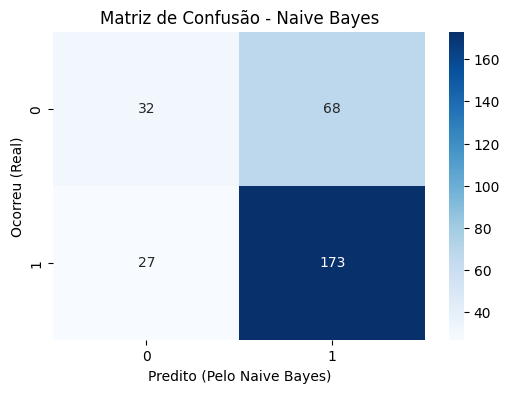

In [16]:
plt.figure(figsize=(6, 4))
sns.heatmap(
    matriz, annot=True, cmap='Blues', xticklabels=['0', '1'],
    yticklabels=['0', '1'], fmt='g'
)

plt.xlabel("Predito (Pelo Naive Bayes)")
plt.ylabel("Ocorreu (Real)")
plt.title("Matriz de Confusão - Naive Bayes")
plt.show()